# Weather Prediction

Hello! 

This notebook is a sample of how to apply a seasonal autoregressive moving average forecasting model to pressure data from NOAA. 

This year I am supporting GWUs Design, Build, Fly team - the competition will occur during April 2020 near McConnell Air Force Base (Witchita, KS). One important consideration for constructing a plane is the likely weather conditions the plane will be flying in.

To attempt and account for this, I made making a proof of concept model to forecastthe pressue in April 2020 at McConnell AFB.

Enjoy! If you have questions/suggestions feel free to email jgroover@gwu.edu

In [1]:
pip install --upgrade --no-deps git+https://github.com/statsmodels/statsmodels.git

  Cloning https://github.com/statsmodels/statsmodels.git to /private/var/folders/hq/_1wnrj_11rl7lxk2mbpvb69h0000gn/T/pip-req-build-t157w1tc
  Stored in directory: /private/var/folders/hq/_1wnrj_11rl7lxk2mbpvb69h0000gn/T/pip-ephem-wheel-cache-egzczyxj/wheels/7b/bd/6d/3192a61f34609bda0eea70342907984dba2ad17c3abb502ce7
Successfully built statsmodels
  Found existing installation: statsmodels 0.11.0.dev0+482.gfad69bc11
    Uninstalling statsmodels-0.11.0.dev0+482.gfad69bc11:
      Successfully uninstalled statsmodels-0.11.0.dev0+482.gfad69bc11
Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
plt.style.use('fivethirtyeight')
matplotlib.rcParams['text.color'] = 'G'

In [2]:
weather_data = pd.read_csv(r'/Users/joshuacurie/my_files/GW/dbf1920/mcconnelafb_weather_0100_0919.csv')
weather_data['datetime'] = weather_data['YEARMODA'].map(lambda YEARMODA: datetime.strptime(str(int(YEARMODA)), '%Y%m%d'))

In [4]:
weather_data.columns

Index(['STN', 'WBAN', 'YEARMODA', 'TEMP', 'TEMP(COUNT)', 'DEWP', 'DEWP(COUNT)',
       'SLP', 'SLP(COUNT)', 'STP', 'STP(COUNT)', 'VISIB', 'VISIB(COUNT)',
       'WDSP', 'WDSP(COUNT)', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP',
       'FRSHTT', 'datetime'],
      dtype='object')

In [5]:
weather_data.tail()

,STN,WBAN,YEARMODA,TEMP,TEMP(COUNT),DEWP,DEWP(COUNT),SLP,SLP(COUNT),STP,...,WDSP,WDSP(COUNT),MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT,datetime
5338,724505,3923,20190828,73.5,18,57.9,18,1019.2,18,970.4,...,4.6,18,9.9,999.9,84.6,59.2,0.00I,999.9,0,2019-08-28
5339,724505,3923,20190829,78.6,23,66.5,23,1015.0,23,966.7,...,10.6,23,17.1,20.0,90.9,70.7,0.00I,999.9,0,2019-08-29
5340,724505,3923,20190830,73.4,21,64.4,21,1016.8,21,968.1,...,8.2,21,29.9,40.0,87.4,65.5,0.59G,999.9,10010,2019-08-30
5341,724505,3923,20190831,69.3,24,60.9,24,1020.0,24,971.3,...,4.4,24,11.1,999.9,78.1,63.7,0.02G,999.9,10000,2019-08-31
5342,724505,3923,20190901,73.0,23,64.0,23,1019.3,23,970.5,...,2.5,23,6.0,999.9,84.9,62.4,0.00G,999.9,0,2019-09-01


# Predicting pressure at the airfield 
Variable: STP/mean station pressue;
Unit: milibars

### Pt 1. Clean the data/organize it by month

In [90]:
#choose the station mean station pressue and date cols from original dataframe
stp = weather_data[['datetime', 'STP']].set_index('datetime')

#in the data, 9999.9 represents a day where there is no record of the pressue so we remove these
stp = stp[stp.STP != 9999.9]

#group the data into each month
stp_monthly = stp.groupby(pd.Grouper(freq='M')).mean()

### Pt 2. Analyze the monthly trends and determine the autoregressive, differencing, and moving average terms (p,d,q)

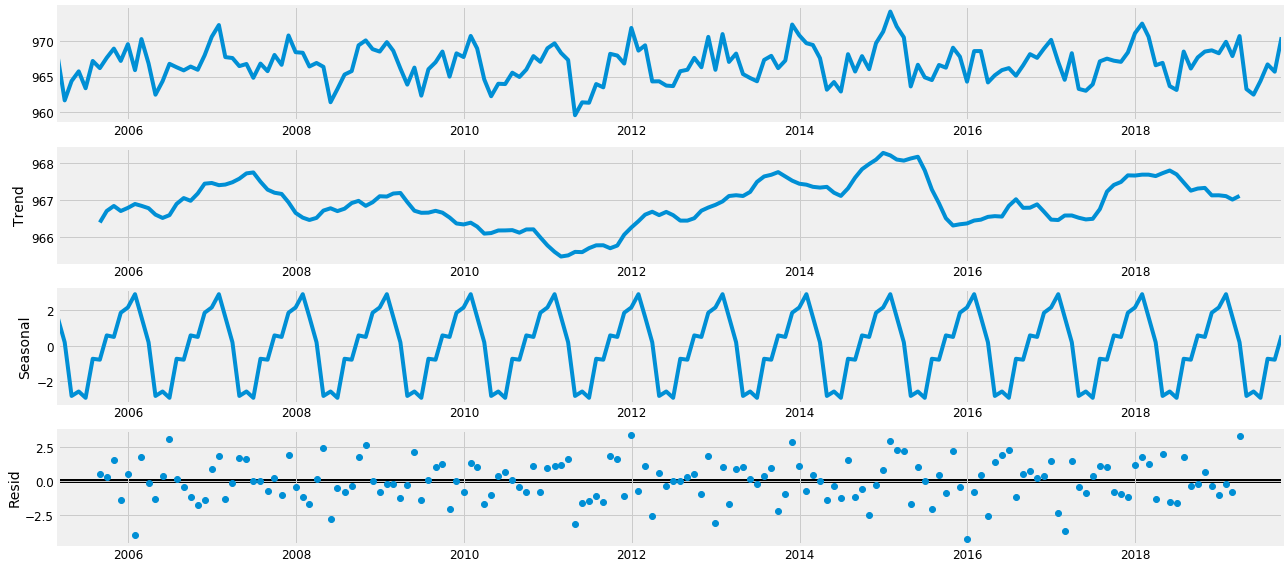

In [56]:
#analyzing the data using a seasonal plot
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(stp_monthly, model='additive')
fig = decomposition.plot()
plt.show()

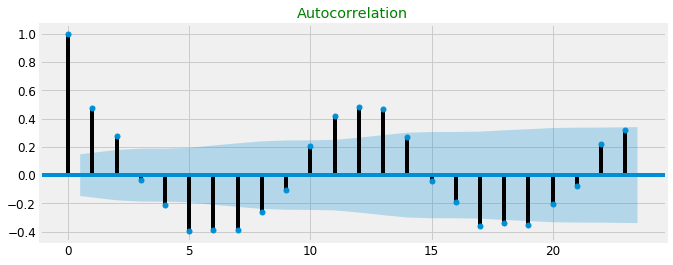

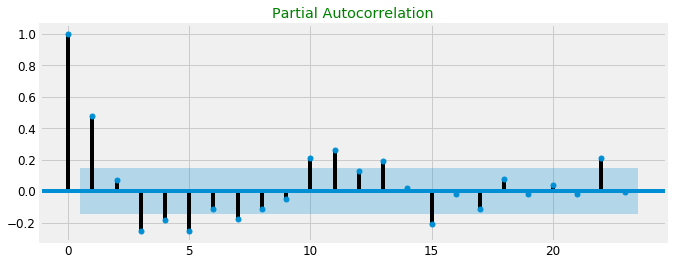

In [57]:
rcParams['figure.figsize'] = 10, 4
ax = sm.graphics.tsa.plot_acf(stp_monthly.STP)
ax2 = sm.graphics.tsa.plot_pacf(stp_monthly.STP)

## Determine p,d,q

### d (difference term)

In [58]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(stp_monthly.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.743477
p-value: 0.066812


> This test is to see if the model is stationary

> Null Ho: Model is not stationary where alpha=.05

> Alternative Ho: Model is stationary

> Since the p_val > .05, we fail to reject the model is not stationary

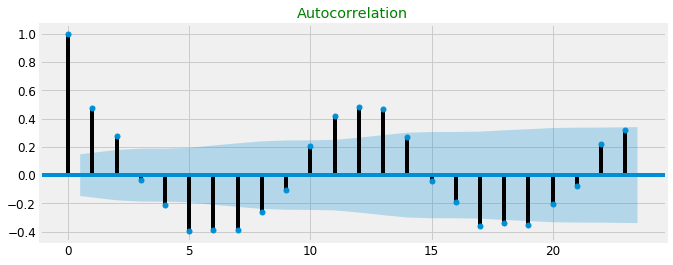

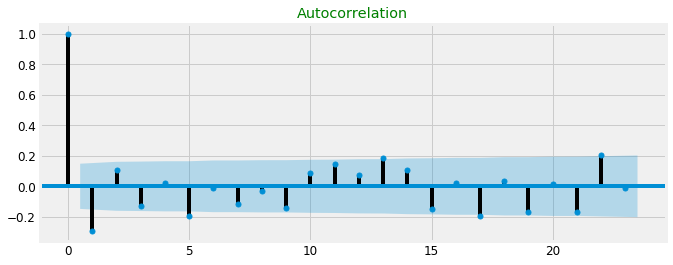

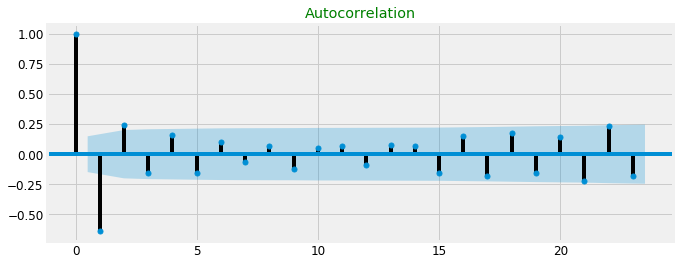

In [60]:
rcParams['figure.figsize'] = 10, 4
org = sm.graphics.tsa.plot_acf(stp_monthly.STP)
dif1 = sm.graphics.tsa.plot_acf(stp_monthly.STP.diff().dropna())
dif2 = sm.graphics.tsa.plot_acf(stp_monthly.STP.diff().diff().dropna())

> Test a few differences (1 & 2) to see when the autocorrelation is most within the blue acceptable range

> A dif of 1 seems to be a good fit between overdifferncing and the original

> Set d=1

### p (Autocorrelation Term)

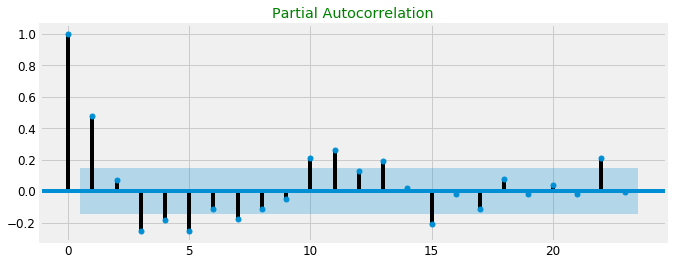

In [61]:
rcParams['figure.figsize'] = 10, 4
org = sm.graphics.tsa.plot_pacf(stp_monthly.STP)

> There are a number of lines that are above the region of signficance for autocorrelation

> Thus we need ot autoregressive term needs to be higher than 0 to correct for it

> Try p=1,2

### q (moving average term)

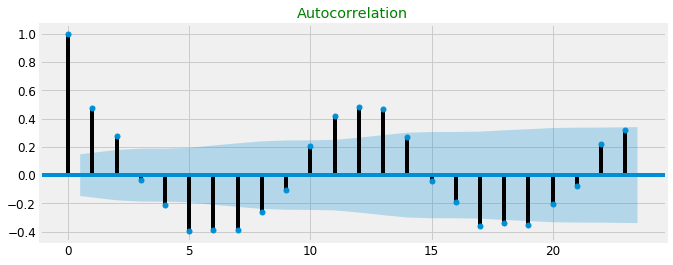

In [62]:
rcParams['figure.figsize'] = 10, 4
org = sm.graphics.tsa.plot_acf(stp_monthly.STP)

> The autocorrelation throughout the data is quite large

> To correct for it, the q term needs to be larger than 0 or 1

> Try q=2,3

### Try the following: (p=2, d=1, q=2), (p=1, d=1, q=2), (p=2, d=1, q=3)

> Choose the one with the lowest loglike value

In [102]:
mod1 = sm.tsa.statespace.SARIMAX(stp_monthly,
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 2, 6))
mod2 = sm.tsa.statespace.SARIMAX(stp_monthly,
                                order=(1,1,2),
                                seasonal_order=(1,1,2,6))
mod3 = sm.tsa.statespace.SARIMAX(stp_monthly,
                                order=(2,1,3),
                                seasonal_order=(2,1,3,6))
results1 = mod1.fit()
results2 = mod2.fit()
results3 = mod3.fit()

print('Results (p=2, d=1, q=2):')
print(results1.summary())
print('-----------------------------------------------------------------------------------------------------------------------------------')
print("Results 2 (p=1, d=1, q=2):")
print(results2.summary())
print('-----------------------------------------------------------------------------------------------------------------------------------')
print("Results 3 (p=2, d=1, q=3):")
print(results3.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results (p=2, d=1, q=2):
                                 Statespace Model Results                                
Dep. Variable:                               STP   No. Observations:                  176
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 6)   Log Likelihood                -353.247
Date:                           Thu, 12 Sep 2019   AIC                            724.495
Time:                                   21:44:37   BIC                            752.664
Sample:                               02-28-2005   HQIC                           735.926
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8538     10.430     -0.082      0.935     -21.296      19.589
ar.L2          0.1

## Which model to use?

> From the model summarys, it looks like the third model of (p=2, d=1, q=3) has the lowest log liklihood

> This model also has the lowest Akaike Information Critera (AIC) at 721 - but adding in additional parameters may be overfitting it

> The Bayesian Information Criterion (BIC) is similar to the adjusted R^2 value in regression, it accounts for the amount of variance a model has while also considering the number of extra predictor terms added into the SARIMA equation - whereas the AIC does not. You can add one million terms to the SARIMA equation and have a perfect AIC value but the model will be overfitted for the data. As such, we should place a higher priority in finding the right balance between amount of variance explained by the model and the generalizability of it

> Since the BIC is lowest for (p=1,d=1,q=2), we will use there parameters for our final model

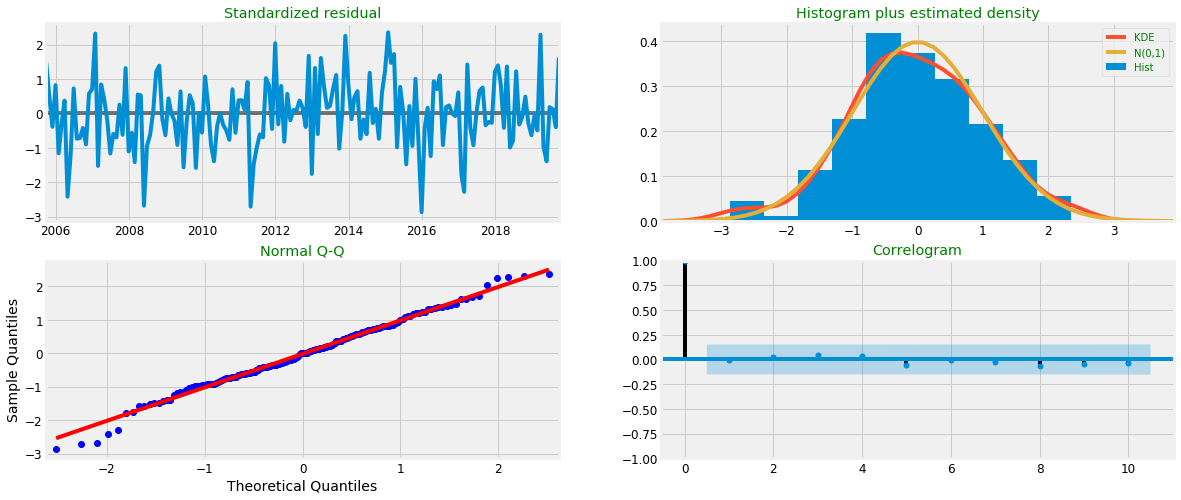

In [103]:
results2.plot_diagnostics(figsize=(18, 8))
plt.show()

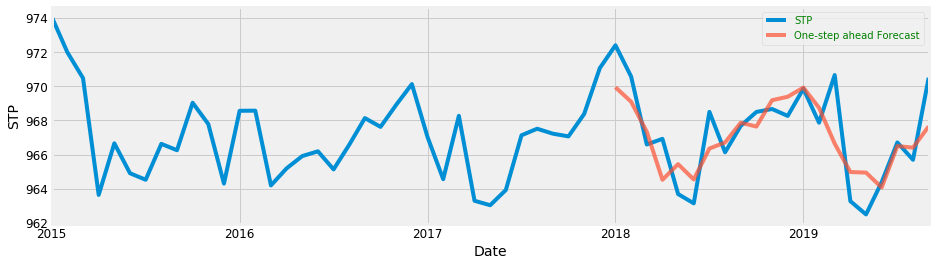

In [111]:
pred = results2.get_prediction(start='2018-01-31', dynamic=False)
pred_ci = pred.conf_int()
ax = stp_monthly['2015':].plot(label='STP')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('STP')
plt.legend()
plt.show()

> This chart graphs the predictions against the actual values for pressure

> The predictions follow the general shape of pressures very well and seem to be a mostly good rough fit

In [73]:
stp_forecasted = pd.DataFrame(pred.predicted_mean, columns=['STP'])
stp_truth = stp['2018-01-02':]
mse = ((stp_forecasted - stp_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is STP    36.67
dtype: float64
The Root Mean Squared Error is STP    6.06
dtype: float64


## Forecasting for the year 2020

> Now is the moment you and my team of engineers have been waiting for.... a forecast!

> The SARIMAX library allows us to use the model to forecast for the following months, the graph of all months is shown below

> While the forecasted data is much more general than the observed data, it will give a very close mean and confidence interval for the pressures

> This allows the design team to optimize the plane for a specific range of pressures and improve the planes performance in its operational enviornemnt!

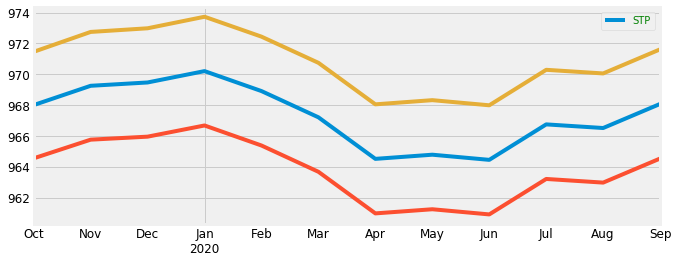

In [108]:
forecast = pd.DataFrame({'STP':results.get_forecast(steps=12, dynamic=False).predicted_mean})
forecast_ci = results2.get_forecast(steps=12, dynamic=False).conf_int()
ax = forecast.plot(label='STP')
forecast_ci['lower STP'].plot(ax=ax, label='lower STP')
forecast_ci['upper STP'].plot(ax=ax, label='upper STP')
plt.show()

In [112]:
df_april= stp[stp.index.month == 4]
date_rng = pd.date_range(start='9/1/2019', end='9/29/2020', freq='M')
forecast = pd.DataFrame({'STP':np.array(forecast.STP), 
                         'lower_conf_int_STP':np.array(forecast_ci['lower STP']), 
                         'upper_conf_int_STP':np.array(forecast_ci['upper STP'])}, 
                         index=date_rng)

In [113]:
forecast[forecast.index.month == 4]

,STP,lower_conf_int_STP,upper_conf_int_STP
2020-04-30,964.804502,961.277097,968.331908


In [116]:
# Something else to consider is the max and min pressures observed in April
# The plane should function in all possible enviorments, and the extremes must also be considered/accounted for in the design process
print('April Min Pressure Observed: {} milibars'.format(df_april.STP.min()))
print('April Max Pressure Observed: {} milibars'.format(df_april.STP.max()))

April Min Pressure Observed: 945.8 milibars
April Max Pressure Observed: 979.4 milibars


# Final Pressure Prediction for April 2020
### $pred = 964.76$ milibars 
### 95% Confidence Interval: [961.25, 968.27] milibars
### Min,Max Vals Observed: [945.8,979.4] milibars